# Add additional features for new reading-focussed pretraining tasks
## Reading rate
predict reading rate at page-level? 
- easiest to do prior to data loading, we have this info at the page level already
- but is this different from the fixation count generated from the present fixation code?
Or at sequence-level?
- do after data loading: use fixation/non-fixation labels to detect discrete fixations, then count, then divide by sequence duration

## Regression
- generate fixation events from fix/nonfix sample-level labels
- identify regression fixations
- classifier:
  - binary (regression fixation vs all other sample types?)
  - 3-class: fixation:non-regression, fixation:regression, saccade
  - 3-class: **regression_fixation, other_fixation, other (incl sacc, blink, uncategorized/missing)**

- Replaces FI pretraining task? 

In [1]:
from pathlib import Path
import pandas as pd
import eyemind
import os
repodir = os.path.dirname(os.path.dirname(eyemind.__file__))
%reload_ext autoreload
%autoreload 2
pd.options.mode.chained_assignment = None  # default='warn'



# Load data as per preprocessing 


In [ ]:
data_path =  os.path.join(repodir,'data/processed/EML1_pageLevel_500+_matchEDMinstances.csv')
gaze_path = os.path.join(repodir,'data/EML/gaze')
instances = pd.read_csv(data_path)

Read EML fixations and regressions DF and add a regression column  
Compare the two, are regressions a strict subset of fixations?  
Or do they apear to have been calculated independently?   

In [ ]:
regressions_path = Path("../data/regressions_info/regressions_reading_pages.csv")
reg_df = pd.read_csv(regressions_path)


In [ ]:
reg_df.columns

reg_df['filename'] = reg_df['ParticipantID']+ '-' + reg_df['identifier']
reg_df['filename'].head(10)



In [ ]:
# functions for labelling at sample-evel based on fixations.py but more general
def label_gaze_timeseries(gaze_df, label_df, label_name='fixation_label',onset_col='tStart',offset_col='tEnd',time_col='tSample'):
    label_df = label_df[[onset_col, offset_col, label_name]]

    label_df[time_col] = label_df.apply(lambda row: list(range(int(row[onset_col]), int(row[offset_col]))), axis=1)
    label_df[label_name] = label_df.apply(lambda row: [row[label_name]]*(int(row[offset_col])-int(row[onset_col])), axis=1)

    sample_label_df = label_df.explode([time_col, label_name])
    sample_label_df = sample_label_df.drop([onset_col, offset_col], axis=1).reset_index(drop=True)
    res_df = gaze_df.merge(sample_label_df , how='left', on=time_col)
    return res_df


In [ ]:
# FIXATION LABEL (uses regression df)
labelled_folder = os.path.join(repodir,"data/EML/gaze+fix")
os.makedirs(labelled_folder, exist_ok=True)
# apply_label_df(regressions_path, gaze_path, labelled_folder, label_name='fixation_label', onset_col='CURRENT_FIX_START',offset_col='CURRENT_FIX_END', time_col='t' )
label_name='fixation_label'
onset_col='CURRENT_FIX_START'
offset_col='CURRENT_FIX_END'
time_col='t' 
label_file=regressions_path
label_df = pd.read_csv(label_file)
label_df["filename"] = label_df.apply(lambda row: f"{row['ParticipantID']}-{row['identifier']}.csv",axis=1)
label_df[label_name]=1
grouped = label_df.groupby("filename")
fix_stats=[]
for filename, df_group in grouped:
    try:
        gaze_df = pd.read_csv(os.path.join(gaze_path,filename))
    except Exception as e:
        # print(f"Couldn't read file: {os.path.join(gaze_path,filename)} because of {e}")
        continue
    labeled_df = label_gaze_timeseries( gaze_df, df_group,label_name,onset_col, offset_col,time_col)
    if labeled_df is not None:
        labeled_df[label_name] = labeled_df[label_name].fillna(0) # saccade if not fixation
        labeled_df.to_csv(Path(labelled_folder, filename),index=False)
        fix_stats.append(labeled_df[label_name].value_counts().sort_index().rename(filename.replace('.csv','')))


fix_stats=pd.DataFrame(fix_stats)
fix_stats.to_csv(Path(labelled_folder + '_counts.csv'))

classes=list(fix_stats.columns)
fix_stats['n']=fix_stats.sum(axis=1)
print('fixation class %:')
print('macroaverage:')
print(100*fix_stats[classes].sum()/fix_stats['n'].sum())
print('microaverage:')
print(100*(fix_stats[classes]/fix_stats['n']).mean())

In [ ]:
# 3-class label (regression, other fixation, not a fixation)
labelled_folder = os.path.join(repodir,"data/EML/gaze+fix+reg")
os.makedirs(labelled_folder, exist_ok=True)
label_name='regression_label'
onset_col='CURRENT_FIX_START'
offset_col='CURRENT_FIX_END'
time_col='t' 

label_file=regressions_path

label_df = pd.read_csv(label_file)
label_df["filename"] = label_df.apply(lambda row: f"{row['ParticipantID']}-{row['identifier']}.csv",axis=1)
label_df[label_name]=label_df['LOCAL_REGRESSION']# 1 if regression, 0 if on-text, NaN if fixation not in IA
label_df[label_name]=label_df[label_name].fillna(0) # all non-regression fixations now have label 0
grouped = label_df.groupby("filename")
reg_stats=[]
for filename, df_group in grouped:
    try:
        gaze_df = pd.read_csv(os.path.join(gaze_path,filename))
    except Exception as e:
        # print(f"Couldn't read file: {os.path.join(gaze_path,filename)} because of {e}")
        continue
    labeled_df = label_gaze_timeseries( gaze_df, df_group, label_name,onset_col, offset_col,time_col)
    if labeled_df is not None:
        labeled_df[label_name] = labeled_df[label_name].fillna(2) # third category is non-fixations
        # labeled_df[label_name] = labeled_df[label_name].replace({0:'fix_other',1:'fix_reg',2:'not_fix'})
        labeled_df.to_csv(Path(labelled_folder, filename),index=False)
        reg_stats.append(labeled_df[label_name].value_counts().sort_index().rename(filename.replace('.csv','')))

print('regression class %')
reg_stats=pd.DataFrame(reg_stats)
reg_stats.to_csv(Path(labelled_folder + '_counts.csv'))

classes=list(reg_stats.columns)
reg_stats['n']=reg_stats.sum(axis=1)
print('regerssion class %:')
print('macroaverage:')
print(100*reg_stats[classes].sum()/reg_stats['n'].sum())
print('microaverage:')
print(100*(reg_stats[classes]/reg_stats['n']).mean())


In [46]:
# read page-level DF and get reading speed

df=pd.read_csv('/Users/roso8920/Dropbox (Emotive Computing)/EML Rosy/DeepGaze/data/EML/EML1_pageLevel_500+_matchEDMinstances.csv')
text=pd.read_csv('/Users/roso8920/Dropbox (Emotive Computing)/EML Rosy/DeepGaze/data/EML/texts-char-word-counts.csv').rename(columns={'text':'Text','pageNum':'PageNum'})
df=df.merge(text,how='left',on=['Text','PageNum'])
df.columns
df['readWPM']=df['wordCount']/df['readtime']*60
df.to_csv('/Users/roso8920/Dropbox (Emotive Computing)/EML Rosy/DeepGaze/data/EML/EML1_pageLevel_500+_matchEDMinstances.csv')

In [ ]:
# check results from pretraining with modified PytorchLightning code but old pretraining tasks


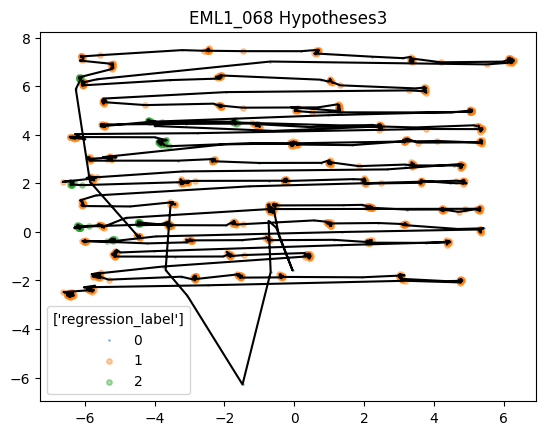

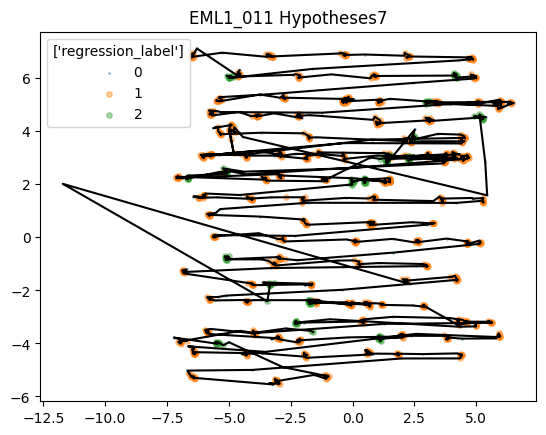

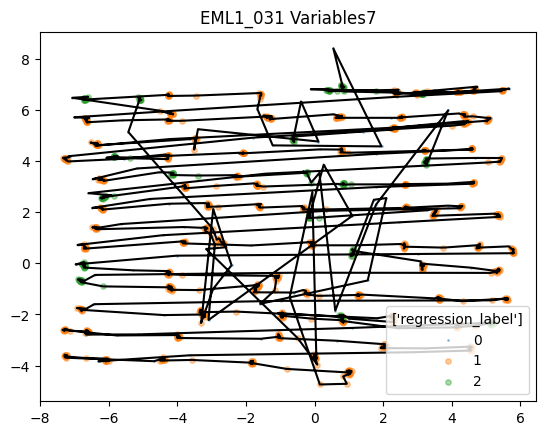

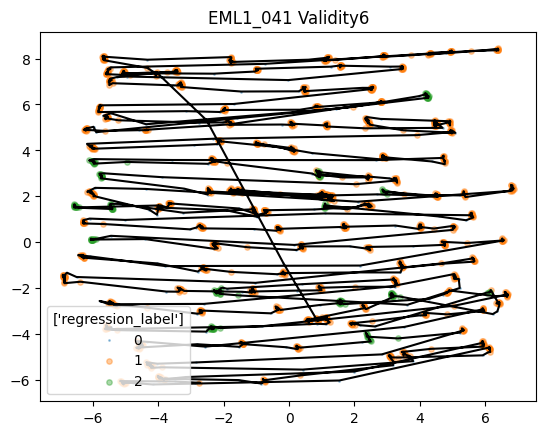

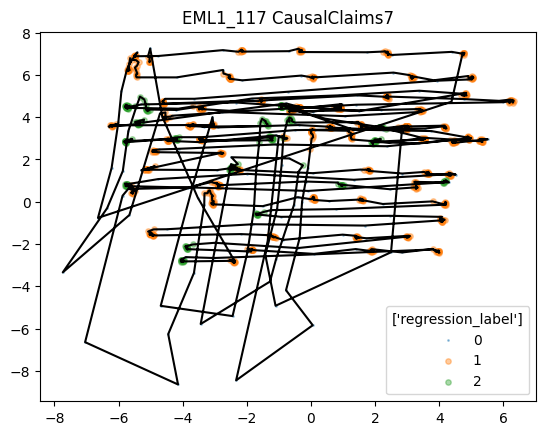

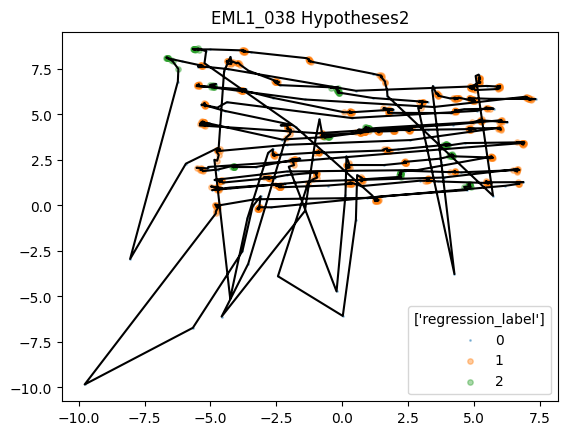

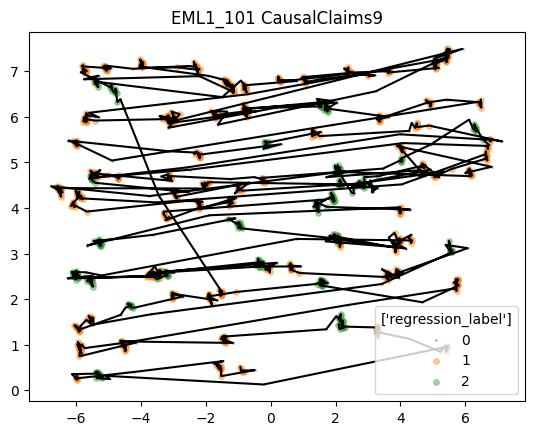

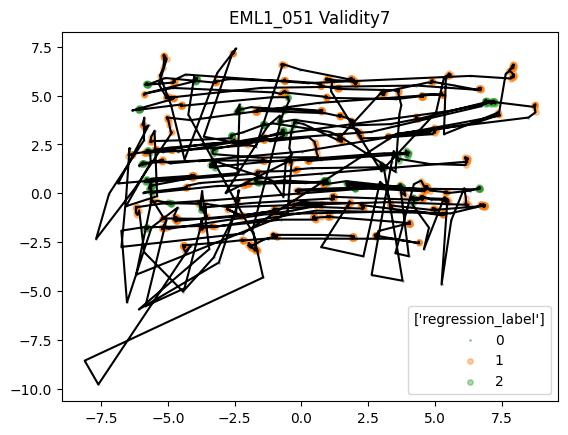

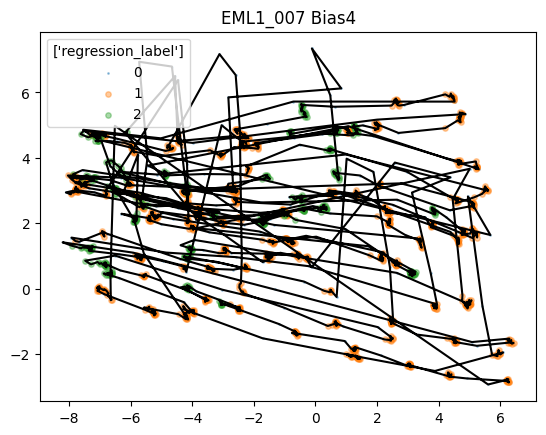

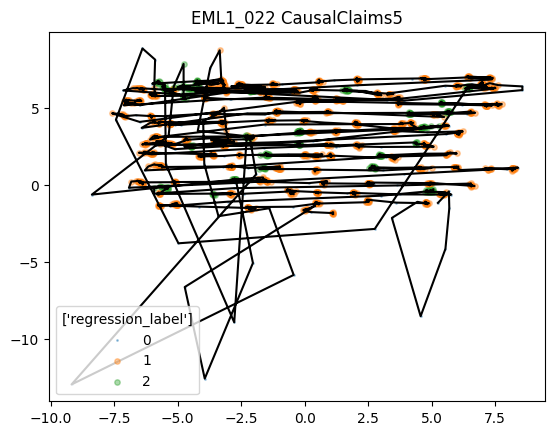

In [23]:
# check new fix/sacc labels actually look ok
from random import sample
from eyemind.preprocessing.signal_normalizing import plot_scanpath
from eyemind.analysis.visualize import plot_scanpath_labels
labelled_folder = os.path.join(repodir,"data/EML/gaze+fix+reg")
filenames=[os.path.join(labelled_folder,f) for f in os.listdir(labelled_folder) if f.endswith('.csv')]

filenames_check = sample(filenames,10)
for f in filenames_check:
    gaze=pd.read_csv(f)
    plot_scanpath_labels(gaze, event=None, exclude=-180, label=['regression_label'])
    